this is to read from kaggle directly

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [ ]:

!kaggle datasets download -d abdulhasibuddin/malayakew-plant-leaf-dataset

 95% 390M/409M [00:01<00:00, 230MB/s]
100% 409M/409M [00:01<00:00, 223MB/s]


this is the extract of the file

In [ ]:
from zipfile import ZipFile
file_name = "/content/malayakew-plant-leaf-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

<ipython-input-9-2d3e2428e4be>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


here we make the pic into array

In [ ]:
def load_images(root_folder, folder_names, target_size=(224, 224)):
    # Lists to store image data (X) and labels (y)
    X = []  # Image data
    y = []  # Corresponding labels

    label_counter = 0  # Counter to assign labels to different classes

    # Loop through each folder representing a class
    for folder_name in folder_names:
        # Construct the path for the current folder
        folder_path = os.path.join(root_folder, folder_name)

        # Check if the folder path exists and is a directory
        if os.path.isdir(folder_path):
            # For each image in the folder
            for filename in sorted(os.listdir(folder_path)):
                # Construct the full path of the image file
                img_path = os.path.join(folder_path, filename)

                # Open the image using PIL
                with Image.open(img_path) as img:
                    # Resize the image to the target size
                    img_resized = img.resize(target_size)

                    # Convert the image to a NumPy array
                    img_array = np.array(img_resized)

                    # Append the image array to the X list
                    X.append(img_array)

                    # Append the corresponding label to the y list
                    y.append(label_counter)

            # Increment the label counter for the next class
            label_counter += 1

    # Convert the lists of images and labels to NumPy arrays and return
    return np.array(X), np.array(y)

In [ ]:
root_folder = '/content/MK/D1/train'
selected_folders = ['Class (1)', 'Class (4)']
X_train, y_train = load_images(root_folder, selected_folders)
root_folder = '/content/MK/D1/test'
X_test, y_test = load_images(root_folder, selected_folders)


In [ ]:
!pip install keras.tuner

In [ ]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

In [ ]:
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (104, 224, 224, 3)
X_test Shape:  (24, 224, 224, 3)
y_train Shape:  (104,)
y_test Shape:  (24,)


In [ ]:
X_train=X_train/255.0
X_test=X_test/255.0

This is only shape of one of them

(256, 256, 3)


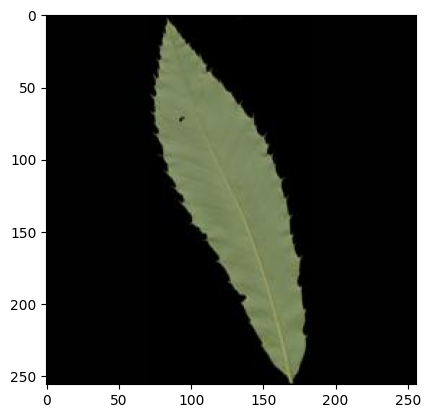

In [ ]:
train_img = plt.imread('/content/MK/D1/train/Class (1)/R_0Class1 (10).jpg')
print (train_img.shape)
plt.imshow(train_img)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rescale=1./255,
    horizontal_flip=True,
    fill_mode='nearest'
# class_mode='categorical'
)

In [ ]:
# Function to apply augmentation twice to each dataset
def augment_dataset(dataset):
    augmented_data = []
    for img in dataset:
        img = np.expand_dims(img, axis=0)  # Expanding dimensions for batch size
        for _ in range(5):  # Apply augmentation twice
            seed = np.random.randint(0, 1000)  # Different seed for each pass
            for batch in datagen.flow(img, batch_size=1, seed=seed):
                augmented_data.append(np.squeeze(batch))  # Remove the batch dimension
                break  # Stop the loop after one augmented image
    return np.array(augmented_data)

# Apply augmentation twice to X_train, X_test, and X_val
X_train_augmented = augment_dataset(X_train)
y_train_augmented = np.repeat(y_train,5, axis=0)


X_test_augmented = augment_dataset(X_test)
y_test_augmented = np.repeat(y_test,5, axis=0)


In [ ]:
X_test_augmented = augment_dataset(X_test)
y_test_augmented = np.repeat(y_test,5, axis=0)

In [ ]:
print("X_train_augmented shape:", X_train_augmented.shape)
print("y_train_augmented shape:", y_train_augmented.shape)

print("X_test_augmented shape:", X_test_augmented.shape)
print("y_test_augmented shape:", y_test_augmented.shape)

In [ ]:
from sklearn.utils import shuffle

# Combine original data with augmented data
X_train_combined = np.concatenate((X_train, X_train_augmented))
y_train_combined = np.concatenate((y_train, y_train_augmented))

X_test_combined = np.concatenate((X_test, X_test_augmented))
y_test_combined = np.concatenate((y_test, y_test_augmented))


# Shuffle the combined data
X_train_combined, y_train_combined = shuffle(X_train_combined, y_train_combined, random_state=42)
X_test_combined, y_test_combined = shuffle(X_test_combined, y_test_combined, random_state=42)

In [ ]:
print(y_train_combined.shape)
print(y_test_combined.shape)

(624,)
(144,)


In [ ]:
from keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from keras.layers import Conv2D
from keras.applications import VGG16,Xception,VGG19
from keras.datasets import cifar10
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import EarlyStopping

from keras_tuner.tuners import RandomSearch


# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# base_model.trainable=False
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


def build_model(hp):
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
     # Tune the number of units in the dense layer
    hp_units = hp.Int('units', min_value=128, max_value=512, step=32)
    model.add(Dense(units=hp_units, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,  # Adjust the number of trials as needed
    directory='tuner_results',
    project_name='vgg16_tuning'
)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(X_train_combined, y_train_combined, batch_size=32)
test_generator = test_datagen.flow(X_test_combined, y_test_combined, batch_size=32)

# Perform the hyperparameter search
tuner.search(train_generator, epochs=10, validation_data=test_generator)

# Get the best model and print the summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


In [ ]:
from keras.models import Model

from keras import backend as K
metrics = [
        'accuracy',
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.FalseNegatives(),
        tf.keras.metrics.FalsePositives(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives(),
        tf.keras.metrics.F1Score()]

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
   monitor='val_loss',patience=3,
     restore_best_weights=True
    )
]
history = best_model.fit(X_train_combined, y_train_combined.astype('float32'), epochs=10,batch_size=32,validation_split=0.10,callbacks=callbacks)

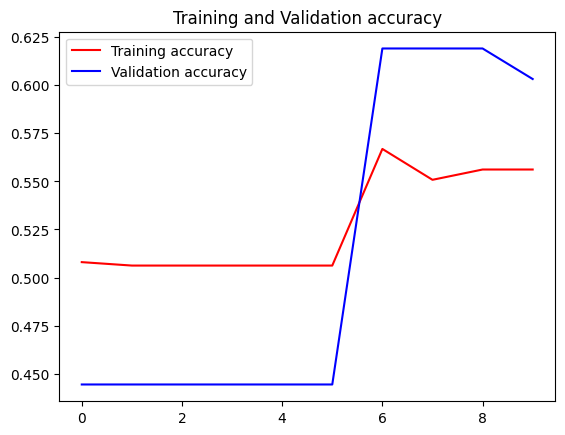

<Figure size 640x480 with 0 Axes>

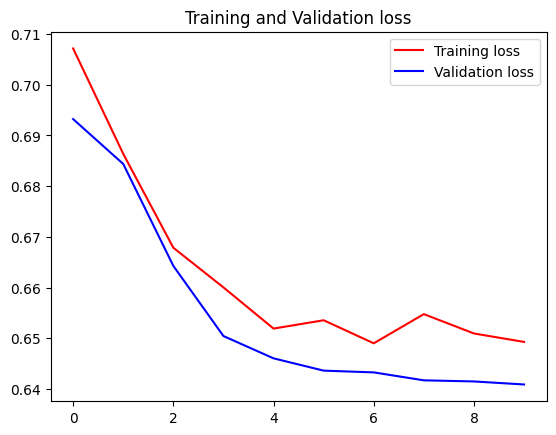

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs,acc,'r',label="Training accuracy")
plt.plot(epochs,val_acc,'b',label="Validation accuracy")
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.title('Training and Validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
best_model.evaluate(X_test_combined,y_test_combined.astype('float32'))

5/5 [==============================] - 55s 11s/step - loss: 0.6372 - accuracy: 0.5764 - recall: 0.9861 - precision: 0.5420 - false_negatives: 1.0000 - false_positives: 60.0000 - true_negatives: 12.0000 - true_positives: 71.0000 - f1_score: 0.6667


[0.637211263179779,
 0.5763888955116272,
 0.9861111044883728,
 0.5419847369194031,
 1.0,
 60.0,
 12.0,
 71.0,
 array([0.6666667], dtype=float32)]